<a href="https://colab.research.google.com/github/abhiyantaabhishek/COVID_19_Detection/blob/master/COVID_19_Detection_with_TFDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
import PIL
from PIL import Image


In [2]:
!git clone https://github.com/abhiyantaabhishek/COVID_19_Detection
%cd COVID_19_Detection

Cloning into 'COVID_19_Detection'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 768 (delta 4), reused 0 (delta 0), pack-reused 750
Receiving objects: 100% (768/768), 88.48 MiB | 41.96 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/COVID_19_Detection


In [3]:
CT_COVID = ['CT_COVID/'+f for f in  os.listdir('CT_COVID')]
CT_NonCOVID = ['CT_NonCOVID/'+f for f in  os.listdir('CT_NonCOVID')]

In [4]:
Data_img = []
label = []
for f in CT_COVID:
  image = Image.open(f).convert('RGB').resize((256,256))
  Data_img.append(np.array(image))
  label.append(1)
  Data_img.append(np.array(image.transpose(PIL.Image.FLIP_TOP_BOTTOM)))
  label.append(1)
  Data_img.append(np.array(image.transpose(PIL.Image.FLIP_LEFT_RIGHT)))
  label.append(1)
  image=np.array(image)
  assert((image[:,:,0] == image[:,:,2]).any())
  assert((image[:,:,0] == image[:,:,1]).any())

for f in CT_NonCOVID:
  image = Image.open(f).convert('RGB').resize((256,256))
  Data_img.append(np.array(image))
  label.append(0)
  Data_img.append(np.array(image.transpose(PIL.Image.FLIP_TOP_BOTTOM)))
  label.append(0)
  Data_img.append(np.array(image.transpose(PIL.Image.FLIP_LEFT_RIGHT)))
  label.append(0)
  image=np.array(image)  
  assert((image[:,:,0] == image[:,:,2]).any())
  assert((image[:,:,0] == image[:,:,1]).any())
Data_img=np.array(Data_img)
label=np.array(label)


In [5]:
class_names = ['COVID_Positive','COVID_Negative']

In [6]:
index = np.array(list(range(len(Data_img))))
np.random.shuffle(index)
data_train_x  = Data_img[:int(len(index)*0.6)]
data_val_x = Data_img[int(len(index)*0.6) : int(len(index)*0.6) + int(len(index)*0.2)]
data_test_x = Data_img[ int(len(index)*0.6) + int(len(index)*0.2) : int(len(index)*0.6) + 2*int(len(index)*0.2)]

data_train_y  = label[:int(len(index)*0.6)]
data_val_y = label[int(len(index)*0.6) : int(len(index)*0.6) + int(len(index)*0.2)]
data_test_y = label[ int(len(index)*0.6) + int(len(index)*0.2) : int(len(index)*0.6) + 2*int(len(index)*0.2)]

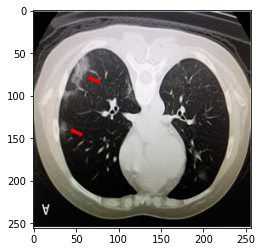

In [7]:
plt.imshow(data_train_x[1])

In [8]:

#train_images = data_train_x / 255.0
#val_images = data_val_x / 255.0
#test_images = data_test_x / 255.0

#train_images = (data_train_x -data_train_x.mean())/data_train_x.std()
#val_images = (data_val_x  - data_val_x.mean())/data_val_x.std()
#test_images = (data_test_x - data_test_x.mean())/data_test_x.std()

train_images = (data_train_x -0.45271412)/33165374
val_images = (data_val_x  - 0.45271412)/33165374
test_images = (data_test_x - 0.45271412)/33165374

In [9]:

train_labels = tf.one_hot(data_train_y, depth=2)
val_labels = tf.one_hot(data_val_y, depth=2)
test_labels = tf.one_hot(data_test_y, depth=2)

In [10]:
data_val_y.shape

(447,)

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [12]:
print(train_dataset)
print(valid_dataset)
print(test_dataset)

<TensorSliceDataset shapes: ((256, 256, 3), (2,)), types: (tf.float64, tf.float32)>
<TensorSliceDataset shapes: ((256, 256, 3), (2,)), types: (tf.float64, tf.float32)>
<TensorSliceDataset shapes: ((256, 256, 3), (2,)), types: (tf.float64, tf.float32)>


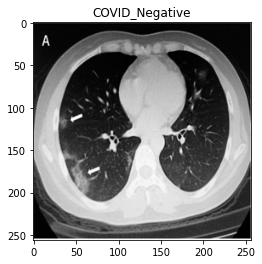

In [13]:
for image, label in train_dataset.take(1):
  plt.figure()
  plt.imshow(image[:,:,0],cmap='gray')
  plt.title(class_names[np.argmax(label)])

In [14]:
BATCH_SIZE = 32
epochs = 10
train_batches = train_dataset.batch(BATCH_SIZE,drop_remainder=True)
validation_batches = valid_dataset.batch(BATCH_SIZE,drop_remainder=True)
test_batches = test_dataset.batch(BATCH_SIZE,drop_remainder=True)

In [15]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 256, 256, 3])

In [16]:
base_model = DenseNet169(input_shape=(256,256,3),include_top=False, weights='imagenet')

51879936/51877672 [==============================] - 1s 0us/step


In [17]:
len(base_model.layers)

595

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.497911 to fit



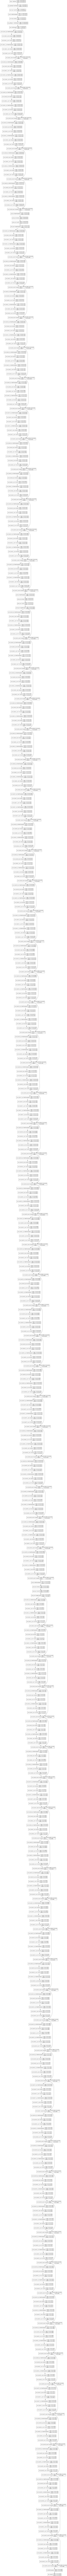

In [18]:
tf.keras.utils.plot_model(base_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [19]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1664)


In [20]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1664)


In [21]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [22]:
base_model.trainable = True

In [23]:

#fine_tune_at = 100
fine_tune_at = 2

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [24]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 8, 8, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3330      
Total params: 12,646,210
Trainable params: 12,487,810
Non-trainable params: 158,400
_________________________________________________________________


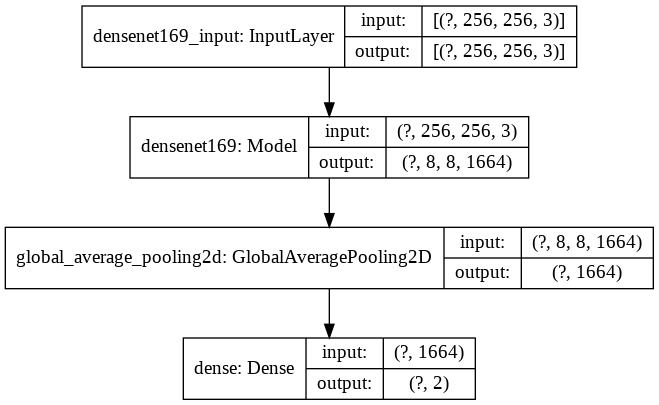

In [26]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [27]:
base_learning_rate = 1e-6
model.compile(loss='categorical_crossentropy',
            optimizer=tf.optimizers.Adam(lr=base_learning_rate),
             metrics=['accuracy'])

In [28]:
validation_batches

<BatchDataset shapes: ((32, 256, 256, 3), (32, 2)), types: (tf.float64, tf.float32)>

In [29]:

validation_steps= np.floor(len(val_images) / BATCH_SIZE)

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

13/13 [==============================] - 2s 119ms/step - loss: 0.7990 - accuracy: 0.0000e+00


In [30]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.80
initial accuracy: 0.00


In [31]:
history = model.fit(train_batches,
                    steps_per_epoch = np.floor(len(train_images) / BATCH_SIZE),
                    epochs=epochs,
                    validation_data=validation_batches,
                    validation_steps = np.floor(len(val_images) / BATCH_SIZE) )

Epoch 1/10
41/41 [==============================] - 15s 366ms/step - loss: 0.9410 - accuracy: 0.3239 - val_loss: 0.8602 - val_accuracy: 0.0000e+00
Epoch 2/10
41/41 [==============================] - 15s 366ms/step - loss: 0.8893 - accuracy: 0.3285 - val_loss: 0.3734 - val_accuracy: 1.0000
Epoch 3/10
41/41 [==============================] - 15s 365ms/step - loss: 0.8485 - accuracy: 0.3521 - val_loss: 0.4207 - val_accuracy: 1.0000
Epoch 4/10
41/41 [==============================] - 15s 364ms/step - loss: 0.8106 - accuracy: 0.3864 - val_loss: 0.5831 - val_accuracy: 1.0000
Epoch 5/10
41/41 [==============================] - 15s 364ms/step - loss: 0.7753 - accuracy: 0.4154 - val_loss: 0.4741 - val_accuracy: 1.0000
Epoch 6/10
41/41 [==============================] - 15s 364ms/step - loss: 0.7423 - accuracy: 0.4642 - val_loss: 0.2954 - val_accuracy: 1.0000
Epoch 7/10
41/41 [==============================] - 15s 364ms/step - loss: 0.7116 - accuracy: 0.5168 - val_loss: 0.2649 - val_accuracy: 1.

In [32]:
#model.fit(train_images, train_labels, epochs=10,validation_data=(val_images))

In [33]:
loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

13/13 [==============================] - 2s 119ms/step - loss: 0.1192 - accuracy: 1.0000


In [34]:
print("Final loss: {:.2f}".format(loss0))
print("Final accuracy: {:.2f}".format(accuracy0))

Final loss: 0.12
Final accuracy: 1.00


In [35]:
##test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

#print('\nTest accuracy:', test_acc)

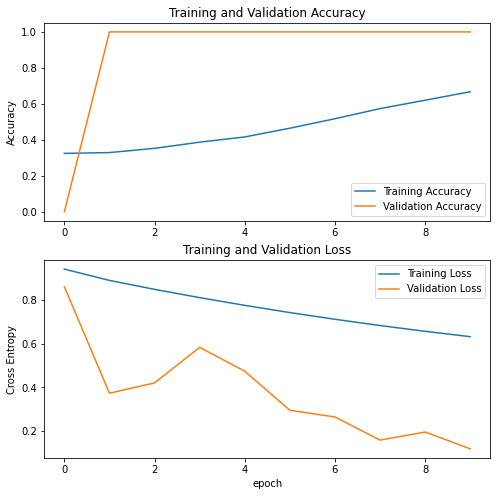

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [37]:
predictions = model.predict(test_images)

In [38]:

test_images[5].shape

(256, 256, 3)

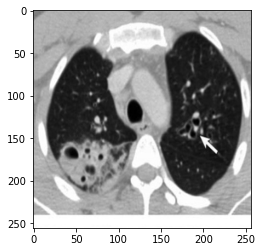

In [42]:
plt.imshow(test_images[5,:,:,0],cmap='gray')

In [40]:

class_names[np.argmax(predictions[5])]

'COVID_Positive'

In [41]:

class_names[np.argmax(test_labels[5])]

'COVID_Positive'